In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_subject_levels

In [2]:
df = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/KI20160914/KI20160914.csv')

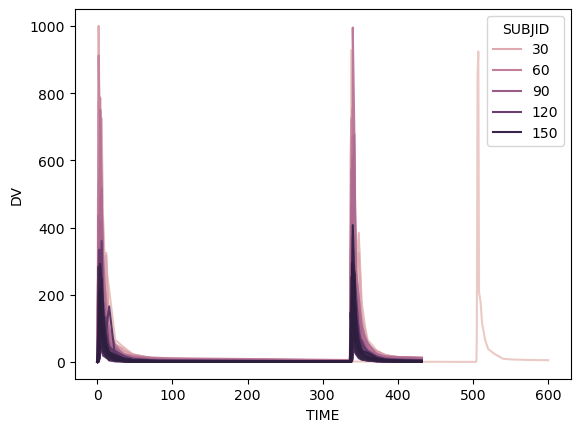

In [3]:
plot_subject_levels(df)

In [4]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
from utils import one_compartment_model, objective_function

In [5]:
#prepare day 1 data
opt_df = df.dropna(subset = 'DV').copy()
opt_df['DV'] = opt_df['DV'].astype(pd.Float32Dtype())
opt_df = opt_df.loc[opt_df['DAY'] == 1, :]

#Within day 1 data, per subject identify the max concentration
#Drop time points occuring before the max, and set the time at that max conc to t=0
dfs = []
for c in opt_df['SUBJID'].drop_duplicates():
    work_df = opt_df.loc[opt_df['SUBJID'] == c, :].reset_index(drop = True)
    max_idx = work_df.loc[work_df['DV'] == work_df['DV'].max(), :].index[0]
    work_df = work_df.iloc[max_idx:, :]
    work_df['TIME'] = work_df['TIME'] - work_df['TIME'].min()
    dfs.append(work_df.copy())
work_df = pd.concat(dfs)

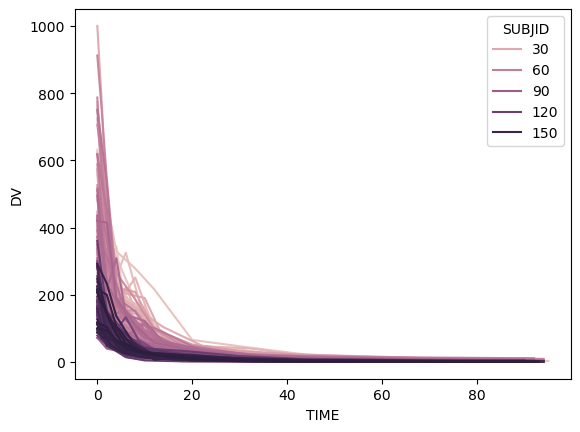

In [6]:
#plot the prepared data
plot_subject_levels(work_df)

In [7]:
import numpy as np
from scipy.optimize import minimize
from joblib import dump, load
import os
from functools import partial
from utils import optimize_with_checkpoint_joblib

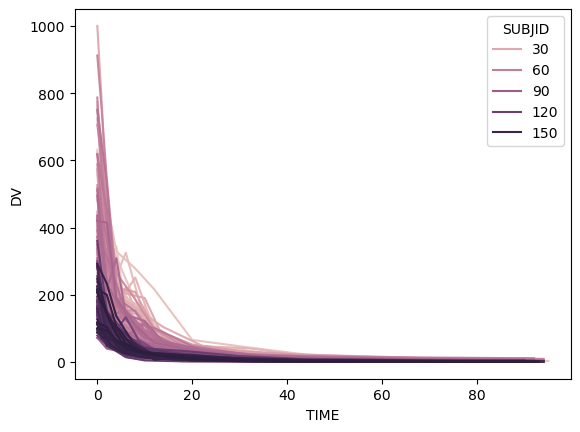

In [8]:
from sklearn.preprocessing import RobustScaler
scale_df = work_df.copy()
#scale_df[['DV']] = RobustScaler().fit_transform(scale_df[['DV']])
mgkg_scaler = RobustScaler()
age_scaler = RobustScaler()
wt_scaler = RobustScaler()

scale_df['MGKG'] = (scale_df['DOSR'] / scale_df['WT'])
scale_df['WT_scale'] = wt_scaler.fit_transform(scale_df[['WT']])
scale_df['MGKG_scale'] = mgkg_scaler.fit_transform(scale_df[['MGKG']])
scale_df['AGE_scale'] = age_scaler.fit_transform(scale_df[['AGE']])
scale_df['DOSR'] = scale_df['DOSR'] / 100
plot_subject_levels(scale_df)

In [9]:
scale_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,MGKG,WT_scale,MGKG_scale,AGE_scale
2,1.0,1.0,1.0,0.0,1.0,3.0,NaN,275.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
3,1.0,1.0,1.0,1.0,2.0,3.0,NaN,244.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
4,1.0,1.0,1.0,2.0,3.0,3.0,NaN,151.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
5,1.0,1.0,1.0,3.0,4.0,3.0,NaN,130.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
6,1.0,1.0,1.0,5.0,6.0,3.0,NaN,147.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,1.0,NaN,7.91,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
11,159.0,1.0,1.0,33.0,36.0,1.0,NaN,3.02,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
12,159.0,1.0,1.0,45.0,48.0,1.0,NaN,1.7,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
13,159.0,1.0,1.0,69.0,72.0,1.0,NaN,1.42,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429


In [10]:
from utils import OneCompartmentModel, ObjectiveFunctionColumn
mod_sse = OneCompartmentModel(dep_vars= {'k':[ ],
                                           'vd':[]}, 
                              #loss_function=sum_of_squares_loss, 
                              optimizer_tol=None
                              )
mod_sse_param = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX' )],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                         model_method='linear',
                                                                         
                                                                         allometric_norm_value=wt_scaler.transform([[70]])[0][0], 
                                                                         
                                                                         )]}, 
                              #loss_function=sum_of_squares_loss, 
                              optimizer_tol=None
                              )

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [11]:
init_summary = mod_sse.init_vals_pd

In [12]:
import pymc as pm

In [13]:
model_params = init_summary.loc[init_summary['population_coeff'], :]
model_params

,model_coeff,model_coeff_dep_var,population_coeff,init_val,allometric,allometric_norm_value
0,k,None,True,-0.510826,False,None
1,vd,None,True,0.693147,False,None


In [14]:
model_param_dep_vars = init_summary.loc[init_summary['population_coeff'] == False, :]
model_param_dep_vars

,model_coeff,model_coeff_dep_var,population_coeff,init_val,allometric,allometric_norm_value


In [15]:
print(f"model_params = pd.DataFrame({model_params.to_dict()})")

model_params = pd.DataFrame({'model_coeff': {0: 'k', 1: 'vd'}, 'model_coeff_dep_var': {0: None, 1: None}, 'population_coeff': {0: True, 1: True}, 'init_val': {0: -0.5108256237659907, 1: 0.6931471805599453}, 'allometric': {0: False, 1: False}, 'allometric_norm_value': {0: None, 1: None}})


In [ ]:
print(f"model_param_dep_vars = pd.DataFrame({model_param_dep_vars.to_dict()})")

model_param_dep_vars = pd.DataFrame({'model_coeff': {}, 'model_coeff_dep_var': {}, 'population_coeff': {}, 'init_val': {}, 'allometric': {}, 'allometric_norm_value': {}})


In [ ]:
model_param_dep_vars.to_dict()

{'model_coeff': {},
 'model_coeff_dep_var': {},
 'population_coeff': {},
 'init_val': {},
 'allometric': {},
 'allometric_norm_value': {}}

In [18]:
def one_compartment_model(t, y, theta ):
    """
    Defines the differential equation for a one-compartment pharmacokinetic model.

    This function calculates the rate of change of drug concentration in the central 
    compartment over time.

    Args:
      t (float): Time point (not used in this specific model, but required by solve_ivp).
      y (list): Current drug concentration in the central compartment.
      k (float): Elimination rate constant.
      Vd (float): Volume of distribution.


    Returns:
      float: The rate of change of drug concentration (dC/dt).
    """
    k, Vd = theta
    C = y[0]  # Extract concentration from the state vector
    dCdt = -(k/Vd) * C  # Calculate the rate of change
    return dCdt

In [19]:
from pytensor.compile.ops import as_op
import pytensor.tensor as pt
import pytensor
from scipy.integrate import solve_ivp
import os

# Set PyTensor flags for debugging
os.environ["PYTENSOR_FLAGS"] = "optimizer=fast_compile,exception_verbosity=high"

In [20]:
work_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT
2,1.0,1.0,1.0,0.0,1.0,300.0,NaN,275.0,0.0,B,1.0,26.0,84.0
3,1.0,1.0,1.0,1.0,2.0,300.0,NaN,244.0,0.0,B,1.0,26.0,84.0
4,1.0,1.0,1.0,2.0,3.0,300.0,NaN,151.0,0.0,B,1.0,26.0,84.0
5,1.0,1.0,1.0,3.0,4.0,300.0,NaN,130.0,0.0,B,1.0,26.0,84.0
6,1.0,1.0,1.0,5.0,6.0,300.0,NaN,147.0,0.0,B,1.0,26.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,100.0,NaN,7.91,1.0,B,1.0,33.0,95.0
11,159.0,1.0,1.0,33.0,36.0,100.0,NaN,3.02,1.0,B,1.0,33.0,95.0
12,159.0,1.0,1.0,45.0,48.0,100.0,NaN,1.7,1.0,B,1.0,33.0,95.0
13,159.0,1.0,1.0,69.0,72.0,100.0,NaN,1.42,1.0,B,1.0,33.0,95.0


In [21]:
#needed_idx = scale_df['TIME'].value_counts()[:10].index.values
scale_df_filter = []
for sub in scale_df['SUBJID'].unique():
    work_df = scale_df.loc[scale_df['SUBJID'] == sub, :].copy()
    tp = work_df['TIME'].values[:10]
    work_df = work_df.loc[work_df['TIME'].isin(tp), :]
    #nrows = len(work_df)
    #if nrows == len(needed_idx):
    scale_df_filter.append(work_df.copy())
scale_df_filter = pd.concat(scale_df_filter)
    

In [22]:
debug_df = scale_df.loc[scale_df['SUBJID'].isin([1, 2]), :]
debug_df = debug_df.loc[(debug_df['TIME'] < 30) & (debug_df['TIME'] != 3), :]

In [23]:
debug_df = scale_df_filter.copy()
#debug_df = debug_df.loc[debug_df['SUBJID'].isin([1, 2]), :]

In [24]:
all_subject_data = debug_df[['SUBJID', 'AGE_scale', 'WT_scale', 'SEX', 'DV']].drop_duplicates(subset = 'SUBJID', keep='first').copy()

In [25]:
pm_df = debug_df.copy().reset_index(drop = True)
pm_subj_df = all_subject_data.copy().reset_index(drop = True)

In [26]:
tps = pm_df.groupby('SUBJID')['TIME'].unique().reset_index().rename(columns = {'TIME':'subj_tp'})
tps_min = pm_df.groupby('SUBJID')['TIME'].min().reset_index().rename(columns = {'TIME':'subj_tp_min'})
tps_max = pm_df.groupby('SUBJID')['TIME'].max().reset_index().rename(columns = {'TIME':'subj_tp_max'})

In [27]:
pm_subj_df = (pm_subj_df.merge(tps, how = 'left', on = 'SUBJID')
                    .merge(tps_min, how = 'left', on = 'SUBJID')
                    .merge(tps_max, how = 'left', on = 'SUBJID')
                    
                    )

In [28]:
pm_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,MGKG,WT_scale,MGKG_scale,AGE_scale
0,1.0,1.0,1.0,0.0,1.0,3.0,NaN,275.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
1,1.0,1.0,1.0,1.0,2.0,3.0,NaN,244.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
2,1.0,1.0,1.0,2.0,3.0,3.0,NaN,151.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
3,1.0,1.0,1.0,3.0,4.0,3.0,NaN,130.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
4,1.0,1.0,1.0,5.0,6.0,3.0,NaN,147.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,159.0,1.0,1.0,13.0,16.0,1.0,NaN,18.700001,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
1525,159.0,1.0,1.0,21.0,24.0,1.0,NaN,7.91,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
1526,159.0,1.0,1.0,33.0,36.0,1.0,NaN,3.02,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
1527,159.0,1.0,1.0,45.0,48.0,1.0,NaN,1.7,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429


In [29]:
import logging

# Configure logging to capture console output
logging.basicConfig(filename='pymc_debug.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [30]:
pm_df['tmp'] = 1
time_mask_df = pm_df.pivot( index = 'SUBJID', columns = 'TIME', values = 'tmp').fillna(0)
time_mask = time_mask_df.to_numpy().astype(bool)
all_sub_tp_alt = pm_df.pivot( index = 'SUBJID', columns = 'TIME', values = 'TIME')

In [31]:
all_sub_tp = np.tile(all_sub_tp_alt.columns, (len(time_mask_df),1)).shape

In [32]:
all_sub_tp

(159, 47)

In [33]:
coords = {'subject':list(pm_subj_df['SUBJID'].values), 
          'obs_id': list(pm_df.index.values)
          }

In [34]:
max_time_points = pm_subj_df['subj_tp'].apply(len).max()
all_subject_tps = np.full((len(coords['subject']), max_time_points), -1.0)
time_mask = np.zeros((len(coords['subject']), max_time_points), dtype=bool)

In [35]:
pm_subj_df['subj_tp'].apply(len).max()

10

In [36]:
from pymc_utils import make_pymc_model

model = make_pymc_model(pm_subj_df, pm_df, model_params, model_param_dep_vars)

Shape of coeff_intercept_i[k]: [159]
Shape of coeff_intercept_i[vd]: [159]
Shape of intial conc: [159]
Shape of subject min tp: [159]
Shape of subject max tp: [159]
Shape of theta_matrix: [159   2]
Shape of tp_data: [159  47]
Shape of tp_data[0,:]: [47]


INFO:2025-01-28 21:28:02,725:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-01-28 21:28:02,729:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Shape of ode_sol: Shape.0
Shape of time_mask_data: Shape.0


In [37]:
pm.model_to_graphviz(model)

TypeError: unhashable type: 'jaxlib.xla_extension.ArrayImpl'

In [38]:
list(model.values_to_rvs.keys())[:-1]

[k_pop,
 k_intercept_mu,
 k_intercept_sigma_log__,
 z_k,
 vd_pop,
 vd_intercept_mu,
 vd_intercept_sigma_log__,
 z_vd,
 sigma_obs_log__]

In [37]:
vars_list = list(model.values_to_rvs.keys())[:-1]

sampler = "DEMetropolisZ"
tune = 20000
draws = 5000
with model:
    trace_DEMZ = pm.sample( cores = 1)


TypeError: unhashable type: 'jaxlib.xla_extension.ArrayImpl'

In [39]:
print(trace_DEMZ.posterior["tmp_sol"].shape)

(1, 1, 2, 17)


In [40]:
print(trace_DEMZ.posterior["sol"].shape)

(1, 1, 20)


In [39]:
trace_DEMZ

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [45]:
trace_DEMZ.posterior.sol[0][0][:,0]

<xarray.DataArray 'sol' (sol_dim_0: 20)> Size: 160B
array([ 275.        ,  274.50094604,  273.00338745,  270.50762939,
        262.52120972,  250.54148865,  214.60253906,  162.69056702,
         10.94802856, -336.46200562,  625.        ,  624.50067139,
        623.00128174,  617.00488281,  607.01165771,  575.03234863,
        527.06335449,  383.15679932,   47.37372971, -432.31448364])
Coordinates:
    chain      int64 8B 0
    draw       int64 8B 0
  * sol_dim_0  (sol_dim_0) int64 160B 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    sol_dim_1  int64 8B 0

In [40]:
trace_DEMZ

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/envs/pySunODE/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/envs/pySunODE/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/envs/pySunODE/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/envs/pySunODE/lib/pyt

KeyboardInterrupt: 

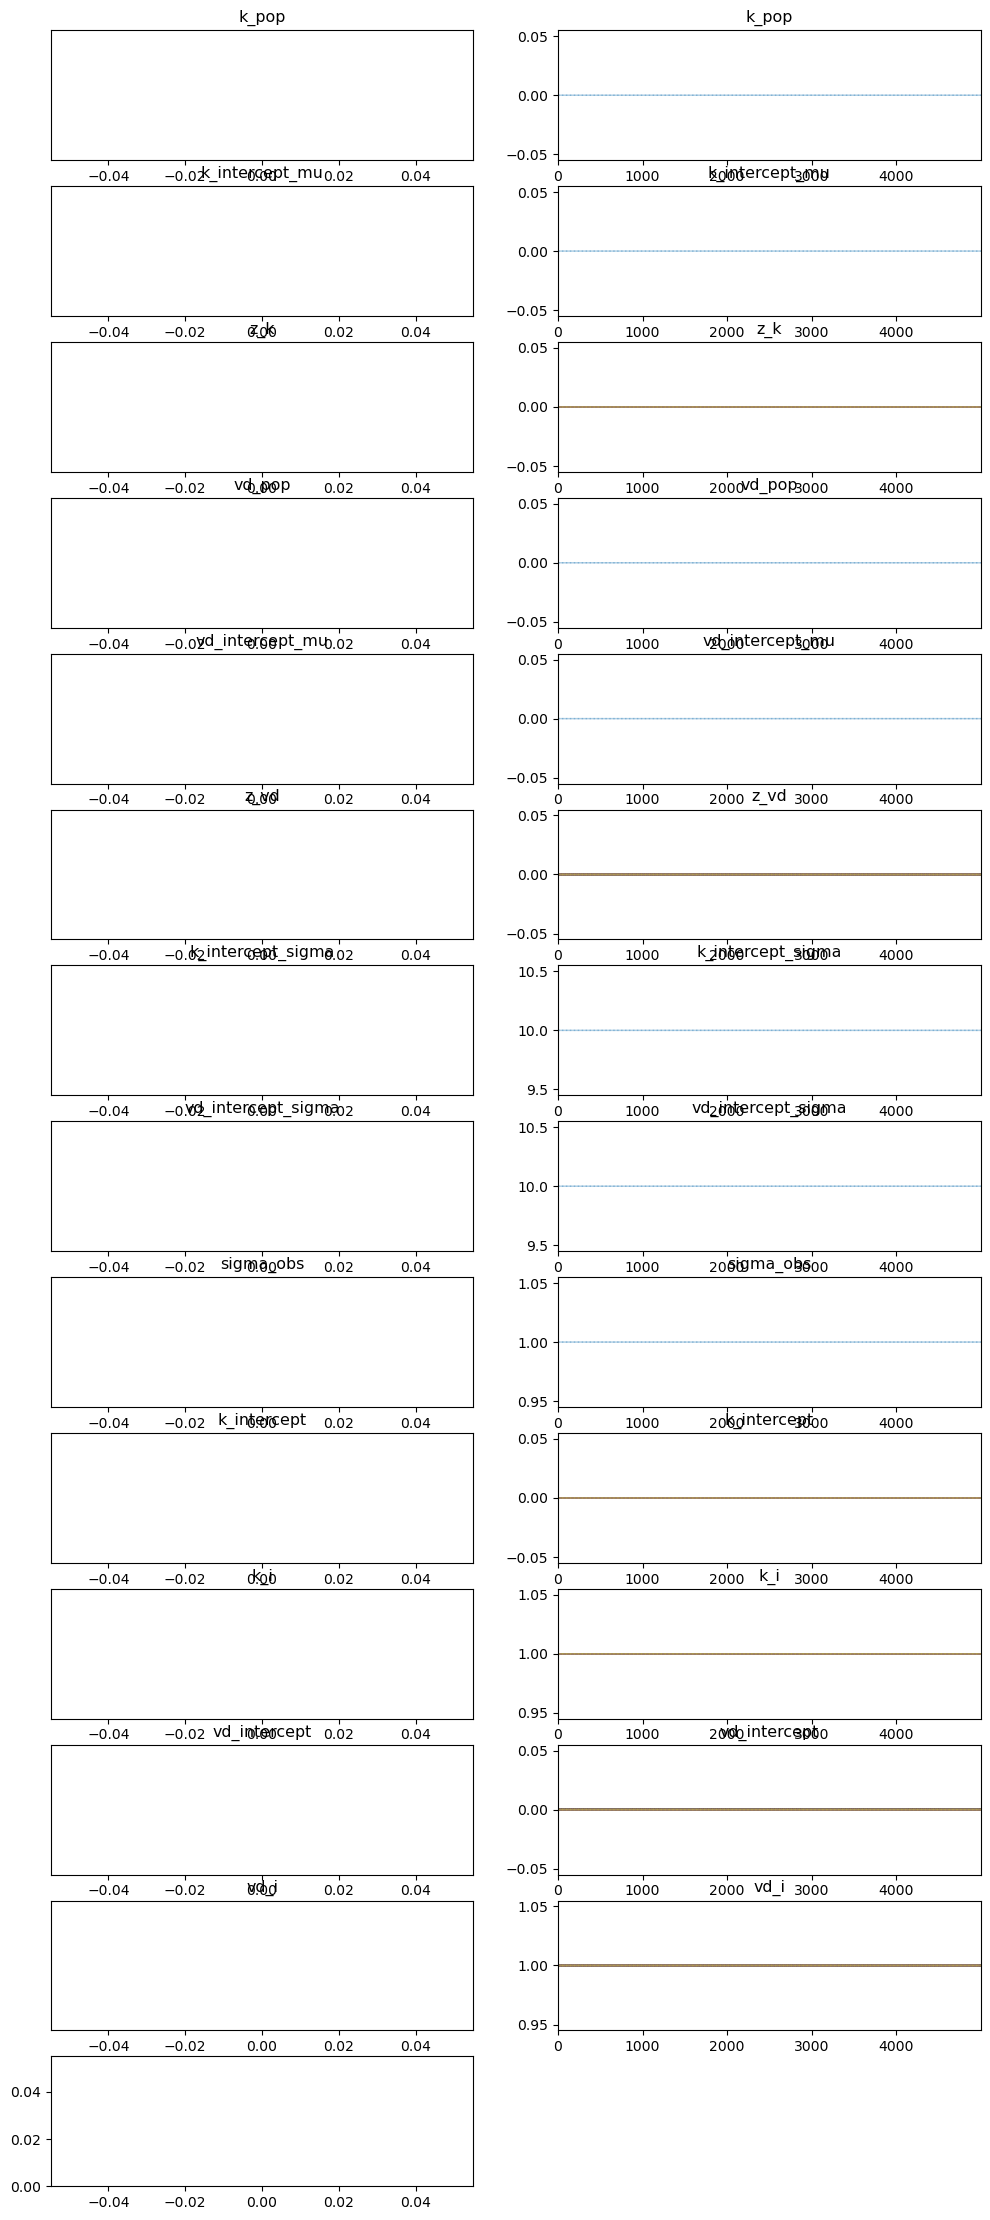

In [41]:
import arviz as az
az.plot_trace(trace_DEMZ)

In [42]:
import arviz as az
az.summary(trace_DEMZ)

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_pop,0.000,0.0,0.000,0.000,0.0,0.0,10000.0,10000.0,NaN
k_intercept_mu,0.000,0.0,0.000,0.000,0.0,0.0,10000.0,10000.0,NaN
z_k[1.0],0.000,0.0,0.000,0.000,0.0,0.0,10000.0,10000.0,NaN
z_k[2.0],0.000,0.0,0.000,0.000,0.0,0.0,10000.0,10000.0,NaN
z_k[3.0],0.000,0.0,0.000,0.000,0.0,0.0,10000.0,10000.0,NaN
...,...,...,...,...,...,...,...,...,...
sol[1524],122.500,0.0,122.500,122.500,0.0,0.0,10000.0,10000.0,NaN
sol[1525],-13.500,0.0,-13.500,-13.500,0.0,0.0,10000.0,10000.0,NaN
sol[1526],-337.500,0.0,-337.500,-337.500,0.0,0.0,10000.0,10000.0,NaN
sol[1527],-805.500,0.0,-805.500,-805.500,0.0,0.0,10000.0,10000.0,NaN


In [29]:
with model:
    res = pm.sample_posterior_predictive(trace_DEMZ)

Sampling: [obs]


Output()

ValueError: Output size (25, 1) is not compatible with broadcast dimensions of inputs (25, 24).
Apply node that caused the error: lognormal_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x7F56094B7060>), [25  1], ExpandDims{axis=0}.0, ExpandDims{axes=[0, 1]}.0)
Toposort index: 9
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(2,)), TensorType(float64, shape=(1, None)), TensorType(float64, shape=(1, 1))]
Inputs shapes: ['No shapes', (2,), (1, 24), (1, 1)]
Inputs strides: ['No strides', (8,), (192, 8), (8, 8)]
Inputs values: [Generator(PCG64) at 0x7F56094B7060, array([25,  1]), 'not shown', array([[1.001827]])]
Outputs clients: [[output[1](lognormal_rv{"(),()->()"}.0)], [output[0](obs)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2662/3741561388.py", line 81, in <module>
    pm.LogNormal("obs", mu=all_conc, sigma=sigma_obs, observed=pm_df["DV"].values.reshape(-1,1))
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 511, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/continuous.py", line 1715, in dist
    return super().dist([mu, sigma], *args, **kwargs)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 580, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.